# Deep Learning with Python

## 6.3 Advanced usage of recurrent neural networks

> 循环神经网络的高级用法

现在，我们通过一个实例，来了解循环神经网络的几个技巧：循环 dropout， 堆叠循环层，双向循环层。

### 温度预测问题

我们将使用一个气象站记录的天气时间序列数据集，在这个数据集中，有每 10 分钟记录的 14 个量(比如气温、气压、湿度、风向等)，这个数据集里有好多年的记录，这里我们只选用 2009—2016 年的。用这个数据集来构建模型，最后目标是输入最近的一些数据(几天的数据点)，预测未来 24 小时的气温。

首先，下载并解压这个数据集：


```sh
cd ~/Somewhere
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip
```

看一下数据:

In [2]:
import os

data_dir = "/Volumes/WD/Files/dataset/jena_climate"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
print(lines[0])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


把数据放到 Numpy 数组中：

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
print(float_data.shape)

(420551, 14)


我们把气温的变化画出来，周期性很明显：

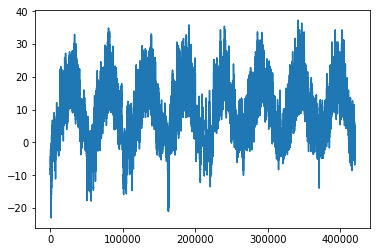

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

再看看前 10 天的数据（数据 10 分钟记一条，所以 1 天是 144 条）：

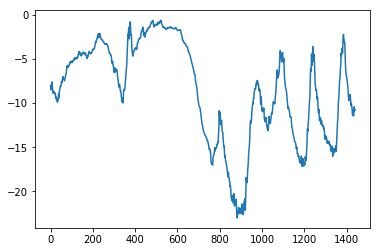

In [5]:
plt.plot(range(1440), temp[: 1440])

这个图可以看出是个冬天的，每天的气温变化也是有周期性的（后面几天比较明显）。

接下来就要开始尝试做预测模型的工作了。首先明确一下我们的问题：给定过去 `lookback` 个时间步(10分钟一个)，我们没 `steps` 步采样一次，让你去预测未来 `delay` 时间步的气温：

- `lookback = 720`: 过去5天的观察数据
- `steps = 6`: 每小时采样一次观察数据
- `delay = 144`: 目标是未来24小时

**数据准备**

1. 数据标准化：让各种特征在数量上差距不大

In [6]:
# 数据标准化

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

2. 把数据放到一个生成器，yield 出 `(samples, targets)`，samples 是输入的数据批，targets 是对应的目标温度数组。

In [7]:
# 生成时间序列样本及其目标的生成器

def generator(data,     # 原始数据
              lookback, # 输入数据包括过去多少个时间步
              delay,    # 目标是未来的多少个时间步
              min_index, max_index,  # 指定从 data 的那个部分抽取
              shuffle=False,   # 打乱样本 or 按顺序抽取
              batch_size=128,  # 每批的样本数
              step=6):         # 数据采样的周期
    
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

调用这个生成器，实例化训练集生成器、验证集生成器、测试集生成器：

In [8]:
# 准备训练生成器、验证生成器和测试生成器

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)

test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

# 验证和测试需要抽取多少次：
val_steps = (300000 - 200001 - lookback)  // batch_size
test_steps = (len(float_data) - 300001 - lookback)  // batch_size

**一种常识的、非机器学习的基准方法**

我们假设温度的时间序列是连续的，并且每天的温度是周期性变化的。这种情况下，可以大胆假设未来 24 小时的温度等于当前的温度。

我们就以此基于常识的非机器学习方法作为基准，用平均绝对误差(MAE)为指标来评估衡量它：

```python
mae = np.mean(np.abs(preds - targets))
```

我们之后做的机器学习模型应该超过这个基准，才能说明机器学习是有效的。

In [9]:
# 计算基于常识的基准方法的 MAE

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    
    return np.mean(batch_maes)
    
mae = evaluate_naive_method()
celsius_mae = mae * std[1]
print(f'mae={mae}, 温度的平均绝对误差={celsius_mae}°C')

mae=0.2897359729905486, 温度的平均绝对误差=2.564887434980494°C


这个误差还是比较大的，所以接下来的目标就是用深度学习的方法来超过这个基准。

**基本的机器学习方法**

在用复杂的、计算代价高的网络(比如 RNN)之前，最好先尝试一下简单的模型能否解决问题。

所以这里我们先用一个简单的全连接网络来尝试处理天气预测问题：

In [9]:
# 绘制历史

import matplotlib.pyplot as plt

def plot_acc_and_loss(history):

    epochs = range(len(history.history['loss']))

    try:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        plt.plot(epochs, acc, 'bo-', label='Training acc')
        plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
    except:
        print('No acc. Skip')
    finally:
        plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 10s 20ms/step - loss: 1.7705 - val_loss: 1.0356
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.5680 - val_loss: 0.3472
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3088 - val_loss: 0.3306
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2708 - val_loss: 0.3071
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2583 - val_loss: 0.3039
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2473 - val_loss: 0.3599
Epoch 7/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2397 - val_loss: 0.3165
Epoch 8/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2343 - val_loss: 0.3205
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2298 - val_loss: 0.3167
Epoch 

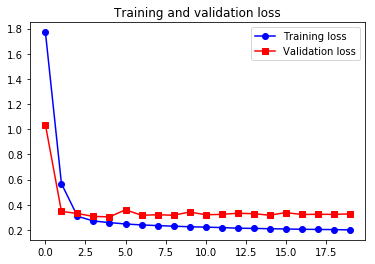

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

plot_acc_and_loss(history)

虽然这个结果里有一部分超过了不机器学习的基准方法，但不够可靠。事实上，要超越基于尝试的基准方法是不容易的，我们的尝试中包含了很多机器难以学到的有用的信息。一般来说，对这种用简单高效解的问题来说，除非我们硬编码让模型去使用这种简单方法，否则靠机器去学习参数是很难找到这个简单模型并进一步改进的。

**循环网络基准**

刚才的全连接网络一开始就用一个 Flatten 把时间序列展平了，所以那个模型实际上是没有考虑『时间』的概念的。要利用起时间的顺序，我们就可以考虑使用循环网络。这次，我们将使用 GRU 层而不是 LSTM：

Epoch 1/20
500/500 [==============================] - 58s 116ms/step - loss: 0.3069 - val_loss: 0.2687
Epoch 2/20
500/500 [==============================] - 56s 113ms/step - loss: 0.2850 - val_loss: 0.2692
Epoch 3/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2765 - val_loss: 0.2704
Epoch 4/20
500/500 [==============================] - 57s 114ms/step - loss: 0.2708 - val_loss: 0.2624
Epoch 5/20
500/500 [==============================] - 57s 115ms/step - loss: 0.2694 - val_loss: 0.2677
Epoch 6/20
500/500 [==============================] - 58s 115ms/step - loss: 0.2624 - val_loss: 0.2604
Epoch 7/20
500/500 [==============================] - 59s 118ms/step - loss: 0.2548 - val_loss: 0.2646
Epoch 8/20
500/500 [==============================] - 60s 119ms/step - loss: 0.2527 - val_loss: 0.2656
Epoch 9/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2494 - val_loss: 0.2691
Epoch 10/20
500/500 [==============================] - 62s 124ms/step - l

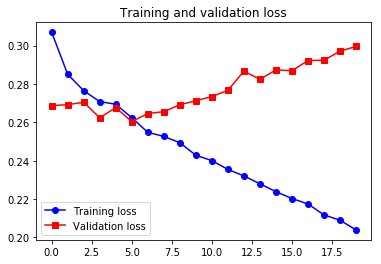

In [13]:
# 训练并评估一个基于 GRU 的模型

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

plot_acc_and_loss(history)

在开始过拟合之前，最好的结果的温度误差是：

In [17]:
print(0.2624 * std[1], '°C')

2.3228957591704926 °C


比一开始的常识模型优秀了。但我们看到，后面过拟合了，在 RNN 里，我们可以用循环 dropout 来对抗过拟合。

**循环 dropout**

我们在前馈网络里面使用 dropout，就是将某一层的输入单元随机得设为0。但在 RNNs 里没有那么简单，在循环层之前使用 dropout 只会阻碍学习，而对结果没有帮助，所以要在循环层中使用 droput。

在循环层中使用 dropout 必须对每个 timestep 使用相同的 mask（掩码，即舍弃单元），掩码不能随 timestep 的改变而有所不同。同时，对于 LSTM、GRU 等循环层，还要将一个不随时间改变的『循环 dropout 掩码』作用于层的内部循环激活。Keras 的 循环层中都内置了这两种 dropout 的实现，只需通过参数 `dropout` 和 `recurrent_dropout` 指定 dropout 的比例即可。

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
500/500 [==============================] - 101s 202ms/step - loss: 0.3491 - val_loss: 0.2865
Epoch 2/40
500/500 [==============================] - 90s 180ms/step - loss: 0.3200 - val_loss: 0.2826
Epoch 3/40
500/500 [==============================] - 93s 185ms/step - loss: 0.3127 - val_loss: 0.2825
Epoch 4/40
500/500 [==============================] - 92s 183ms/step - loss: 0.3074 - val_loss: 0.2783
Epoch 5/40
500/500 [==============================] - 92s 183ms/step - loss: 0.3046 - val_loss: 0.2757
Epoch 6/40
500/500 [==============================] - 90s 179ms/step - loss: 0.2987 - val_loss: 0.2797
Epoch 7/40
500/500 [==============================] - 89s 179ms/step - loss: 0.2950 - val_loss: 0.2886
Epoch 8/40
500/500 [==============================] - 90s 180ms/step - loss: 0.2891 - val_loss: 0.2837
Epoch 9/40
500/500 [==============================] - 90s 179ms/step - loss: 0.2851 - val_loss: 0.2

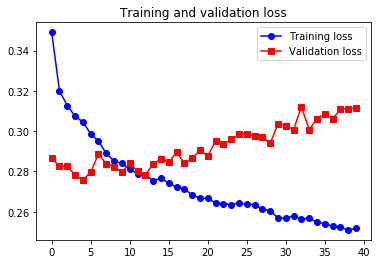

In [10]:
# 训练并评估一个使用 dropout 正则化的基于 GRU 的模型

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.4, 
                     recurrent_dropout=0.4, 
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=40,    # 使用了 dropout 的网络需要更长的时间才能收敛
                              validation_data=val_gen, 
                              validation_steps=val_steps)

plot_acc_and_loss(history)

这个做出来没有书上好，不知道为什么。

**循环层堆叠**

解决了过拟合的问题，现在要进一步提高精度。刚才只用了一个循环层，可以考虑再加几个，堆叠起来，增加网络容量。实际上，循环层的堆叠不用堆的特别多，谷歌翻译也只用了7个超大的LSTM层堆叠在一起。

在 Keras 中堆叠循环层，记得中间层应该返回完整的 3D 输出序列张量，不能只返回最后一个时间步的输出(这个行为是默认的)：

Epoch 1/40
500/500 [==============================] - 225s 450ms/step - loss: 0.3214 - val_loss: 0.2784
Epoch 2/40
500/500 [==============================] - 229s 459ms/step - loss: 0.3029 - val_loss: 0.2721
Epoch 3/40
500/500 [==============================] - 247s 494ms/step - loss: 0.2925 - val_loss: 0.2747
Epoch 4/40
500/500 [==============================] - 265s 531ms/step - loss: 0.2877 - val_loss: 0.2684
Epoch 5/40
500/500 [==============================] - 279s 558ms/step - loss: 0.2791 - val_loss: 0.2749
Epoch 6/40
500/500 [==============================] - 294s 588ms/step - loss: 0.2747 - val_loss: 0.2691
Epoch 7/40
500/500 [==============================] - 297s 593ms/step - loss: 0.2689 - val_loss: 0.2816
Epoch 8/40
500/500 [==============================] - 251s 501ms/step - loss: 0.2649 - val_loss: 0.2779
Epoch 9/40
500/500 [==============================] - 242s 485ms/step - loss: 0.2586 - val_loss: 0.2754
Epoch 10/40
500/500 [==============================] - 245s 489m

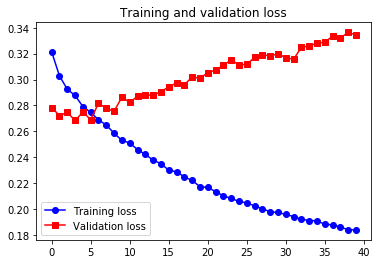

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,  # 输出完整输出序列
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_acc_and_loss(history)

这个也和书上有所差距。但可以看出，堆叠循环层并没有带来太多的性能提升。

**使用双向 RNN**

Bidirectional RNNs (双向循环网络) 是 RNN 的变种，有时可以比 RNN 性能更好，尤其是在自然语言处理上，双向 RNN 被称为深度学习 NLP 的瑞士军队。

RNN 是依赖于序列的时间或者其他顺序的，打乱或反转时间步，RNN 从序列中提取的表示就完全不同了。利用了 RNN 对顺序的这种敏感性，双向 RNN 包含两个普通 RNN，分别沿正序和逆序对输入序列进行处理，最后将它们学到的表示合在一起，这样就可能学习到被单向 RNN 忽略的模式。

之前，我们默认按时间顺序去训练，现在我们可以试试逆序去处理。要逆序，只需在数据生成器最后方向输出就行了 `yield samples[:, ::-1, :], targets)`:

In [12]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)

val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

Epoch 1/20
500/500 [==============================] - 61s 121ms/step - loss: 0.4796 - val_loss: 0.4788
Epoch 2/20
500/500 [==============================] - 58s 117ms/step - loss: 0.4488 - val_loss: 0.4791
Epoch 3/20
500/500 [==============================] - 63s 125ms/step - loss: 0.3956 - val_loss: 0.4613
Epoch 4/20
500/500 [==============================] - 59s 118ms/step - loss: 0.3605 - val_loss: 0.4170
Epoch 5/20
500/500 [==============================] - 60s 121ms/step - loss: 0.3400 - val_loss: 0.3806
Epoch 6/20
500/500 [==============================] - 66s 131ms/step - loss: 0.3145 - val_loss: 0.3766
Epoch 7/20
500/500 [==============================] - 64s 128ms/step - loss: 0.2948 - val_loss: 0.3513
Epoch 8/20
500/500 [==============================] - 63s 126ms/step - loss: 0.2795 - val_loss: 0.3469
Epoch 9/20
500/500 [==============================] - 65s 129ms/step - loss: 0.2701 - val_loss: 0.3365
Epoch 10/20
500/500 [==============================] - 62s 124ms/step - l

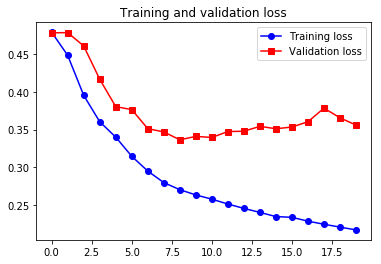

In [14]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)
plot_acc_and_loss(history)

这个效果并不好。是这样的，对于气温预测，当然是近期的数据比较有用、而很长时间之前的信息意义不大，循环层随着 timesteps 的前进会丢失一些老的信息，所以这个问题用正序的结果比逆序的结果好。

但对于文本信息的处理，一个单词对理解句子的重要性通常并不取决于它在句子中的位置。也就是说，虽然单词顺序对理解语言很重要，但使用哪种顺序并不重要。所以，在处理一些文本问题时，正序和逆序可能得到很类似的结果：

Epoch 1/10
157/157 [==============================] - 53s 339ms/step - loss: 0.4945 - acc: 0.7638 - val_loss: 0.4783 - val_acc: 0.8256
Epoch 2/10
157/157 [==============================] - 54s 345ms/step - loss: 0.3198 - acc: 0.8755 - val_loss: 0.5395 - val_acc: 0.7596
Epoch 3/10
157/157 [==============================] - 54s 346ms/step - loss: 0.2566 - acc: 0.9046 - val_loss: 0.3488 - val_acc: 0.8586
Epoch 4/10
157/157 [==============================] - 54s 346ms/step - loss: 0.2130 - acc: 0.9245 - val_loss: 0.3651 - val_acc: 0.8726
Epoch 5/10
157/157 [==============================] - 54s 344ms/step - loss: 0.1923 - acc: 0.9336 - val_loss: 0.3638 - val_acc: 0.8818
Epoch 6/10
157/157 [==============================] - 53s 341ms/step - loss: 0.1662 - acc: 0.9435 - val_loss: 0.4075 - val_acc: 0.8764
Epoch 7/10
157/157 [==============================] - 53s 341ms/step - loss: 0.1461 - acc: 0.9489 - val_loss: 0.3723 - val_acc: 0.8798
Epoch 8/10
157/157 [==============================] - 5

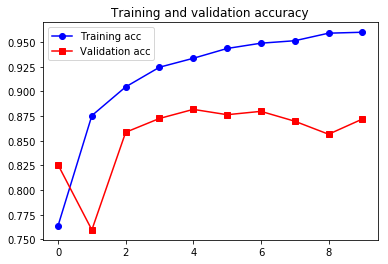

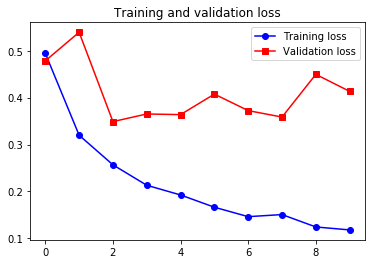

In [17]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
plot_acc_and_loss(history)

这个逆序训练的 IMDB 结果和正序的区别不大。

如果我们把正序和逆序结合起来，从不同的视角去查看数据，相互补充被彼此忽略的内容，就有可能提高模型的性能。这就是双向 RNN 要做的事。

![双向 RNN 层的工作原理](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghmsndu024j311s0jejtx.jpg)

在 Keras 中，使用 Bidirectional 层来实现双向 RNN：

Epoch 1/10
157/157 [==============================] - 50s 317ms/step - loss: 0.5840 - acc: 0.6994 - val_loss: 0.4705 - val_acc: 0.7818
Epoch 2/10
157/157 [==============================] - 45s 285ms/step - loss: 0.3490 - acc: 0.8637 - val_loss: 0.4346 - val_acc: 0.7974
Epoch 3/10
157/157 [==============================] - 44s 283ms/step - loss: 0.2682 - acc: 0.8992 - val_loss: 0.6617 - val_acc: 0.7542
Epoch 4/10
157/157 [==============================] - 44s 283ms/step - loss: 0.2263 - acc: 0.9189 - val_loss: 0.3449 - val_acc: 0.8794
Epoch 5/10
157/157 [==============================] - 45s 285ms/step - loss: 0.1988 - acc: 0.9301 - val_loss: 0.4799 - val_acc: 0.8106
Epoch 6/10
157/157 [==============================] - 45s 286ms/step - loss: 0.1832 - acc: 0.9366 - val_loss: 0.4068 - val_acc: 0.8378
Epoch 7/10
157/157 [==============================] - 46s 293ms/step - loss: 0.1710 - acc: 0.9420 - val_loss: 0.3501 - val_acc: 0.8768
Epoch 8/10
157/157 [==============================] - 4

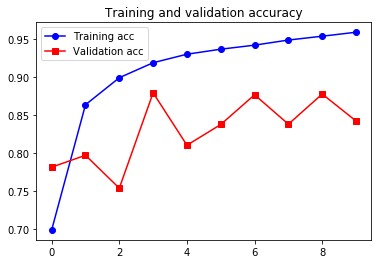

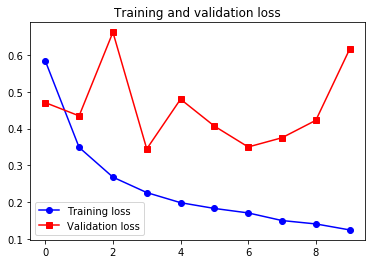

In [18]:
# 在 IMDB 上训练并评估一个双向 LSTM

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

plot_acc_and_loss(history)

接下来，我们尝试将双向 RNN 的方法应用于温度预测任务。

Epoch 1/40
500/500 [==============================] - 81s 163ms/step - loss: 0.3022 - val_loss: 0.2796
Epoch 2/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2761 - val_loss: 0.2619
Epoch 3/40
500/500 [==============================] - 76s 152ms/step - loss: 0.2699 - val_loss: 0.2671
Epoch 4/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2630 - val_loss: 0.2625
Epoch 5/40
500/500 [==============================] - 76s 152ms/step - loss: 0.2584 - val_loss: 0.2744
Epoch 6/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2537 - val_loss: 0.2726
Epoch 7/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2464 - val_loss: 0.2713
Epoch 8/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2416 - val_loss: 0.2783
Epoch 9/40
500/500 [==============================] - 79s 158ms/step - loss: 0.2370 - val_loss: 0.2787
Epoch 10/40
500/500 [==============================] - 78s 156ms/step - l

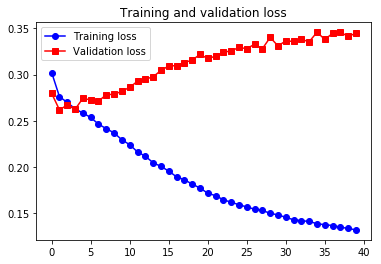

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)
plot_acc_and_loss(history)

**Going even further**

接下来还可以尝试：

- 增加层的单元个数
- 调节 RMSprop 的学习率
- 尝试用 LSTM 层代替 GRU 层
- 在循环层上面(后面)使用更大的密集连接回归器（更大的 Dense 层或 Dense 层的堆叠）
- 在测试集上运行性能最佳的模型，防止模型对验证集过拟合

温馨提示：不要用这个搞气温预测的方法去“预测证券价格哦。在市场上，过去的表现并不能很好地预测未来的收益。Looking in the rear-view mirror is a bad way to drive.